In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
import random
import time

/home/shuyu/Documents/Projects/anomaly-detection/anomaly-env/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/shuyu/Documents/Projects/anomaly-detection/anomaly-env/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from data_loader import DataGenerator
from models import VAEmodel, lstmKerasModel
from trainers import vaeTrainer

from utils import process_config, create_dirs, get_args




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
conv_1: Tensor("encoder/conv2d/LeakyRelu:0", shape=(?, 16, 1, 32), dtype=float32)
conv_2: Tensor("encoder/conv2d_1/LeakyRelu:0", shape=(?, 8, 1, 64), dtype=float32)
conv_3: Tensor("encoder/conv2d_2/LeakyRelu:0", shape=

finish encoder: 
Tensor("encoder/MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(?, 6), dtype=float32)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
decoded_2 is: Tensor("decoder/Reshape_1:0", shape=(?, 4, 1, 128), dtype=float32)
decoded_3 is: Tensor("decoder/Reshape_2:0", shape=(?, 8, 1, 64), dtype=float32)
decoded_4 is: Tensor("decoder/Reshape_3:0", shape=(?, 16, 1, 32), dtype=float32)
decoded_5 is: Tensor("decoder/Reshape_4:0", shape=(?, 32, 1, 16), dtype=float32)


decoded_6 is: Tensor("decoder/conv2d_4/BiasAdd:0", shape=(?, 24, 1, 1), dtype=float32)
finish decoder: 
Tensor("decoder/Reshape_5:0", shape=(?, 24, 1), dtype=float32)


sigma2: 
Tensor("sigma2_dataset/add:0", shape=(), dtype=float32)



The total number of trainable parameters in the encoder model is: 306308
The total number of trainable parameters in the decoder model is: 331121
The total number of trainable parameters in the sigma2_dataset model is: 1
Total number of trainable parameters in the VAE network is: 637430

gvs for dataset: [(<tf.Tensor 'gradients/encoder/conv2d/Conv2D_grad/tuple/control_dependency_1:0' shape=(3, 1, 1, 32) dtype=float32>, <tf.Variable 'encoder/conv2d/kernel:0' shape=(3, 1, 1, 32) dtype=float32_ref>), (<tf.Tensor 'gradients/encoder/conv2d/BiasAdd_grad/tuple/control_dependency_1:0' shape=(32,) dtype=float32>, <tf.Variable 'encoder/conv2d/bias:0' shape=(32,) dtype=float32_ref>), (<tf.Tensor 'gradients/encoder/conv2d_1/Conv2D_grad/tuple/control_dependency_1:0'

Model loaded.


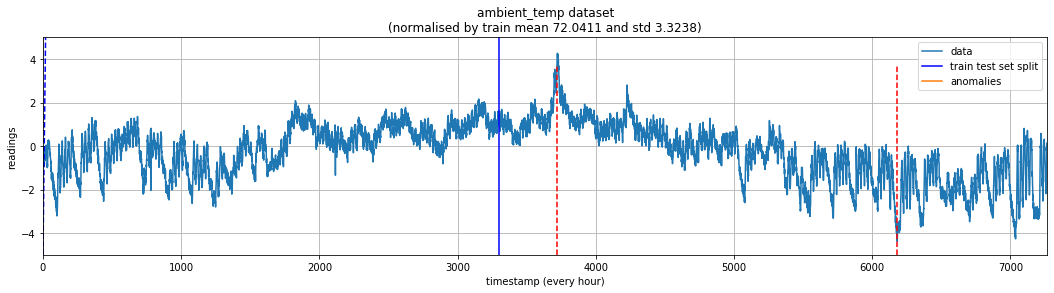

In [4]:
# load VAE model
config = process_config('NAB_config.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir']])
# create tensorflow session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# create your data generator
data = DataGenerator(config)
# create a CNN model
model_vae = VAEmodel(config)
# create a CNN model
trainer_vae = vaeTrainer(sess, model_vae, data, config)
model_vae.load(sess)

In [5]:
# load LSTM model
lstm_model = lstmKerasModel(data)
lstm_model.produce_embeddings(config, model_vae, data, sess)
lstm_nn_model = lstm_model.create_lstm_model(config)
lstm_nn_model.summary()   # Display the model's architecture

# checkpoint path
checkpoint_path = config['checkpoint_dir_lstm'] + "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# load weights if possible
lstm_model.load_model(lstm_nn_model, config, checkpoint_path)

Finish processing the embeddings of the entire dataset.
The first a few embeddings are
[[ 0.17247011 -0.22706668  0.10567407  1.46979868 -0.45379767 -0.04899756]
 [ 0.89554071 -0.14358392  0.05794337  0.77279425 -0.11094926 -0.01017963]
 [-0.3820312  -0.11391592  0.03068142  0.4360275  -0.1690331   0.03521615]
 [-0.08965711 -0.1099499   0.05083127  0.21980846 -0.21936606  0.02607238]
 [-0.59764969 -0.09072936  0.00572591  0.77470148 -1.2825768  -0.02157694]]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 64)             18176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 64)             33024     
____________________________________________________________

In [6]:
# load normalised time series
save_dir = '../datasets/NAB-known-anomaly/'
dataset = config['dataset']
filename = '{}.npz'.format(dataset)
result = np.load(save_dir+filename, allow_pickle=True)

# slice into rolling windows and rolling sequences
def slice_rolling_windows_and_sequences(config, time_seq):
    n_sample = len(time_seq)
    print("The given sequence has {} samples".format(n_sample))
    n_vae_win = n_sample - config['l_win'] + 1
    rolling_windows = np.zeros((n_vae_win, config['l_win']))
    for i in range(n_vae_win):
        rolling_windows[i] = time_seq[i:i + config['l_win']]
        sample_m = np.mean(rolling_windows, axis=1)
        sample_std = np.std(rolling_windows, axis=1)

        n_lstm_seq = n_sample - config['l_seq']*config['l_win']+1
        lstm_seq = np.zeros((n_lstm_seq, config['l_seq'], config['l_win']))
    for i in range(n_lstm_seq):
        cur_seq = time_seq[i:i+config['l_seq']*config['l_win']]
        for j in range(config['l_seq']):
            lstm_seq[i,j] = cur_seq[config['l_win']*j:config['l_win']*(j+1)]
    
    return rolling_windows, lstm_seq, sample_m, sample_std

test_windows, test_seq, test_sample_m, test_sample_std = slice_rolling_windows_and_sequences(config, result['test'])
test_windows = np.expand_dims(test_windows, -1)
test_seq = np.expand_dims(test_seq, -1)
print(test_windows.shape)
print(test_seq.shape)

The given sequence has 3967 samples
(3944, 24, 1)
(3800, 7, 24, 1)


In [7]:
# Evaluate ELBO and LSTM prediction error on the validation set
# evaluate some anomaly detection metrics
def evaluate_vae_anomaly_metrics_for_a_window(test_win):
    feed_dict = {model_vae.original_signal: np.expand_dims(test_win, 0),
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}

    # VAE reconstruction error
    recons_win_vae = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict))
    test_vae_recons_error = np.sum(np.square(recons_win_vae - test_win))

    # VAE latent embedding likelihood
    vae_code_mean, vae_code_std = sess.run([model_vae.code_mean, model_vae.code_std_dev], feed_dict=feed_dict)
    test_vae_kl = 0.5 * (np.sum(np.square(vae_code_mean)) + \
                            np.sum(np.square(vae_code_std)) - \
                            np.sum(np.log(np.square(vae_code_std))) - config['code_size'])

    # VAE ELBO loss
    sigma2 = 0.0005
    input_dims = model_vae.input_dims
    sigma_regularisor = input_dims/2. * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error/sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo

def evaluate_lstm_anomaly_metric_for_a_seq(test_seq):
    feed_dict = {model_vae.original_signal: test_seq,
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}
    vae_embedding = np.squeeze(sess.run(model_vae.code_mean, feed_dict=feed_dict))
    #print(vae_embedding.shape)
    lstm_embedding = np.squeeze(lstm_nn_model.predict(np.expand_dims(vae_embedding[:config['l_seq']-1], 0), batch_size=1))
    lstm_embedding_error = np.sum(np.square(vae_embedding[1:] - lstm_embedding))
    
    # LSTM prediction error
    feed_dict_lstm = {model_vae.original_signal: np.zeros((config['l_seq'] - 1, config['l_win'], 1)),
                      model_vae.is_code_input: True,
                      model_vae.code_input: lstm_embedding}
    recons_win_lstm = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict_lstm))
    lstm_recons_error = np.sum(np.square(recons_win_lstm - np.squeeze(test_seq[1:])))
    return lstm_recons_error, lstm_embedding_error

n_val_vae = data.val_set_vae['data'].shape[0]
n_val_lstm = data.val_set_lstm['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in range(n_val_vae):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][i])

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
for i in range(n_val_lstm):
    val_lstm_recons_error[i], val_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.val_set_lstm['data'][i])

In [8]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=False):
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+'reconstruction_error_histogram.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
    print("Median: {}".format(np.median(test_anomaly_list)))
    print("Mean: {}".format(np.mean(test_anomaly_list)))
    print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

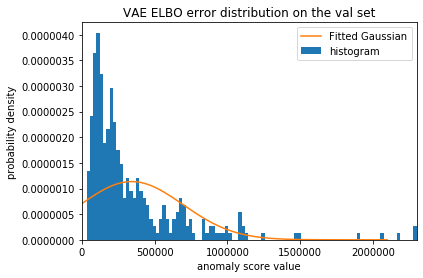

25% percentile: 121744.2474722339
75% percentile: 413057.94965233264
Median: 216648.32864517497
Mean: 343012.38294987555
Std dev: 351324.07385281794
These windows scored the top 1% of anomaly metric (2020021.6749168357): 
[ 15  16  30 120]


In [9]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

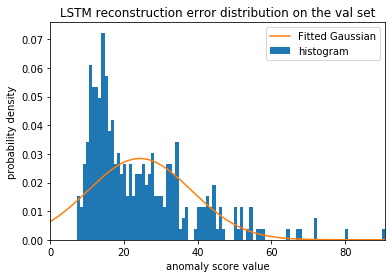

25% percentile: 13.755453838388199
75% percentile: 31.833954746434383
Median: 19.920141433927398
Mean: 24.274860126502983
Std dev: 14.047650889584348
These windows scored the top 1% of anomaly metric (71.62912486006059): 
[  4  12  23 280]


In [10]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m, lstm_recons_std = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [11]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
for i in range(n_test_lstm):
    test_lstm_recons_error[i], test_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

All windows' reconstruction error is computed.
The total number of windows is 3800


25% percentile: 20.37703441258043
75% percentile: 64.19659420774028
Median: 40.17208775934447
Mean: 50.1183906800014
Std dev: 38.78739433445794
These windows scored the top 1% of anomaly metric (174.4369601779371): 
[ 298  299  322  323  346  347  348 2709 2710 2711 2712 2738 2739 2759
 2760 2761 2762 2783 2784 3696 3708 3709 3710 3711 3712 3713 3714 3715
 3716 3717 3718 3719 3720 3731 3732 3733 3734 3735]


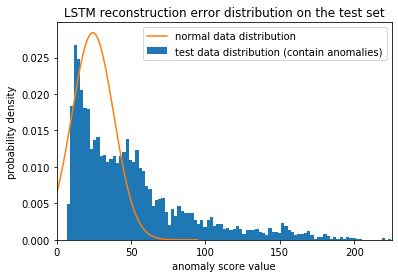

In [12]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m, std=lstm_recons_std, xlim=None, saveplot=True)

In [13]:
# Produce the ground truth anomaly indices 
if result['idx_split'][0] == 0:
    idx_anomaly_test = result['idx_anomaly_test']
else:
    idx_anomaly_test = result['idx_anomaly_test'][1]
    
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in range(len(idx_anomaly_test)):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_test[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

(3800,)


In [14]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    test_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    idx_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold))
    
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    
    return list(idx_error)

In [15]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    n_anomaly = len(anomaly_index)
    idx_detected_anomaly_extended = list(idx_detected_anomaly)
    for i in range(n_anomaly):
        #print(idx_detected_anomaly)
        for j in idx_detected_anomaly:
            if j in anomaly_index[i]:
                in_original_detection = set(idx_detected_anomaly_extended)
                currect_anomaly_win = set(anomaly_index[i])
                idx_detected_anomaly_extended = idx_detected_anomaly_extended + list(currect_anomaly_win - in_original_detection)
                #print(j)
                break
                
    return list(np.sort(idx_detected_anomaly_extended))

In [16]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP = 0
    n_FP = 0
    n_detection = len(idx_detected_anomaly)
    for i in range(n_detection):
        if test_labels[idx_detected_anomaly[i]] == 1:
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1
    
    idx_undetected = list(set(np.arange(len(test_labels)))- set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if test_labels[i] == 1:
            n_FN = n_FN + 1
    
    return n_TP, n_FP, n_FN

In [17]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    # compute true positive
    n_TP, n_FP, n_FN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2* (precision * recall)/(precision + recall)
    
    return precision, recall, F1, n_TP, n_FP, n_FN

In [18]:
n_threshold = 200
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(test_lstm_recons_error), np.amax(test_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, anomaly_index_lstm)
    precision_aug[i], recall_aug[i], F1_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)
    i = i + 1
    #print(precision, recall, F1)

In [19]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.46136618141097424
Best threshold is 88.13362868690591
At this threshold, precision is 0.36983842010771995, recall is 0.6130952380952381
Average precision is 0.3790288677021922

Augmented detection:
Best F1 score is 0.9911504424778761
Best threshold is [198.75342694 197.65818141]
At this threshold, precision is [0.98245614 0.98245614], recall is [1. 1.]
Average precision is 0.9824561403508771


In [20]:
# Now select a threshold
threshold = 198

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 198

PR evaluation using augmented detection:
Precision: 0.9824561403508771
Recall: 1.0
F1: 0.9911504424778761
TP: 336
FP: 6
FN: 0


In [21]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [22]:
def plot_detected_anomalies(idx_detection, interval, dataset, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    
    if result['idx_split'][0] == 0:
        t_test = result['t_test']
        test = result['test']
        idx_anomaly_test = result['idx_anomaly_test']
    else:
        t_test = result['t_test'][1]
        test = result['test'][1]
        idx_anomaly_test = result['idx_anomaly_test'][1]
        
    
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test)
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title("{} dataset test sequence\n(normalised by train mean {:.4f} and std {:.4f})\n Detection method: {}".format(dataset, 
                                                                                        result['train_m'], 
                                                                                        result['train_std'],
                                                                                        detection_method))
    axs.legend(('data', 'true anomalies', 'detected anomalies', 'detected anomaly window'))
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

Detected 3 sequences


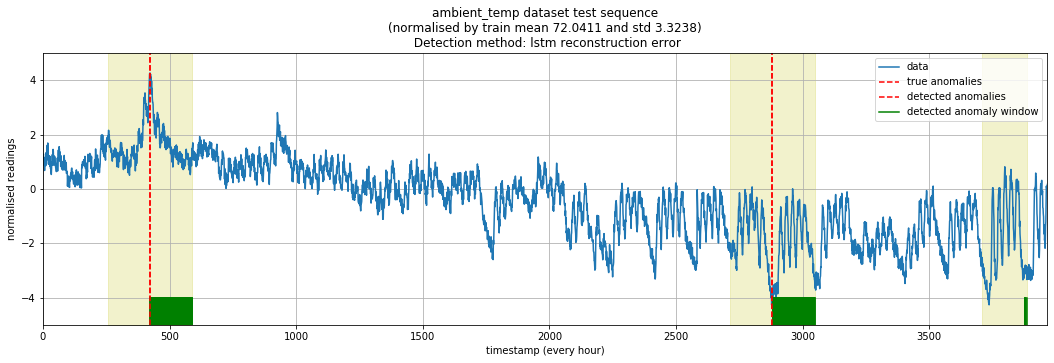

In [24]:
plot_detected_anomalies(idx_detection_augmented, 
                        interval=config['l_win']*config['l_seq']/2, 
                        dataset=dataset, 
                        result=result, 
                        detection_method='lstm reconstruction error',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)